# RTML Final, 2023

st123012 Todsavad Tangtortan 

Welcome to the midterm exam, version 2023!

Prepare your answer to each question, writing your answers directly in this notebook, print as PDF, and turn in via Google Classroom by the deadline.

You may

You have 2.5 hours to complete the exam. Good luck!

## Question 1 (25 points)

Using a ResNet50 model pretrained on ImageNet, obtain the top 5 classes for the following image.

<img src="boat.png">

Optional hints:
1. Use the torchvision implementation of ResNet50.
2. Normalize the RGB values of the image using the ImageNet means (0.485, 0.456, 0.406) and standard deviations (0.229, 0.224, 0.225), resize to 256, and center crop to 224x224.
3. Run the image through the model, find the indices of the top 5 classes, and convert them to class labels using the [list of ImageNet clsses](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

In [60]:
# 1. Use the torchvision implementation of ResNet50.
# 2. Normalize the RGB values of the image using the ImageNet means (0.485, 0.456, 0.406) 
# and standard deviations (0.229, 0.224, 0.225), resize to 256, and center crop to 224x224.
# Place your code here
import warnings
warnings.filterwarnings("ignore")
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F
import numpy as np
from torchvision.models import resnet50

# Set device to GPU or CPU
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

model = resnet50(pretrained=True)
model.eval()

img = Image.open("boat.png").convert('RGB')
convert_tensor = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
img = data_transforms(img).unsqueeze(0)

In [61]:
prediction = model(img).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()

*List the top 5 classes according to the model here.*

In [92]:
# 3. Run the image through the model, find the indices of the top 5 classes, 
# convert them to class labels using the [list of ImageNet clsses]
import urllib
url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
urllib.request.urlretrieve(url, filename) 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [93]:
top5_prob, top5_catid = torch.topk(prediction, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

canoe 0.775122344493866
paddle 0.15282931923866272
speedboat 0.023857442662119865
yawl 0.008557415567338467
catamaran 0.007173469755798578


## Question 2 (25 points)

Obtain instance segmentation masks for the image in Question 1 using pretrained Mask R-CNN and YOLACT models.

#### Mask RCNN

In [9]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection

# Load a model pre-trained on COCO and put it in inference mode

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)
print('Loading weights from file')
# model.load_state_dict(torch.load('mask-rcnn-06-epochs.pth'))
model.eval()

Loading pretrained model...
Loading weights from file


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [10]:
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

In [11]:
import torchvision.transforms as T

def process_single_image(img_path, rotate=False):
    if rotate == True:
        im = Image.open(img_path).rotate(180)
    else:
        im = Image.open(img_path)
    transform = T.ToTensor()
    img = transform(im).unsqueeze(0)
    return img

image_path = 'boat.jpg'
img = process_single_image(image_path, rotate=False).to(device)
predictions = model(img)
print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)

Prediction keys: ['boxes', 'labels', 'scores', 'masks']
Boxes shape: torch.Size([34, 4])
Labels shape: torch.Size([34])
Scores shape: torch.Size([34])
Masks shape: torch.Size([34, 1, 535, 800])


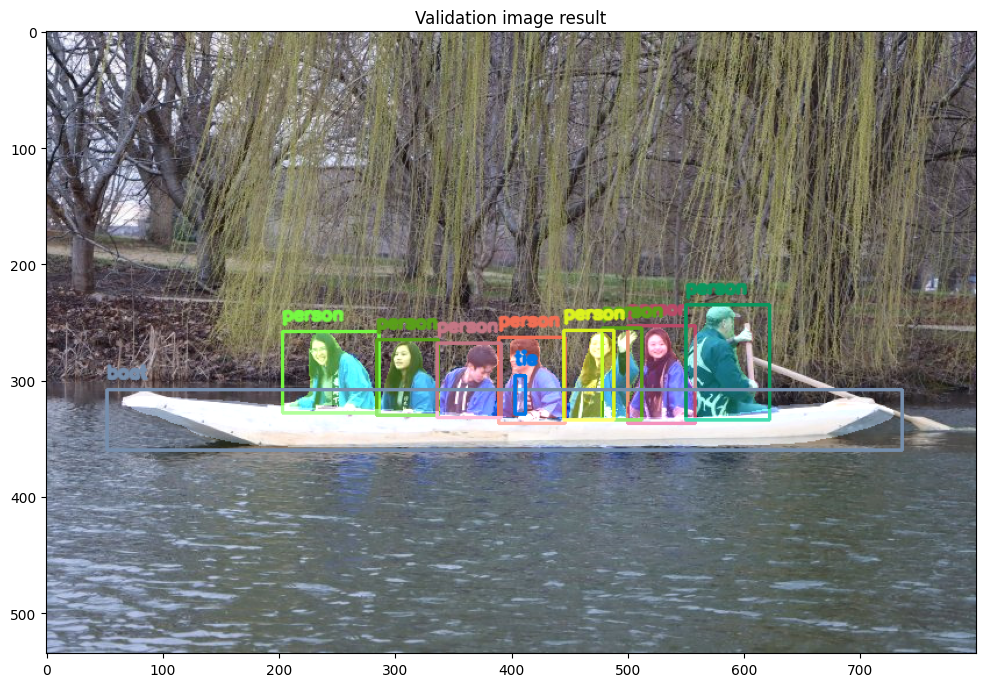

In [12]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

def plot_single_image(masked_img):
    plt.figure(1, figsize=(12, 9), dpi=100)
    plt.imshow(masked_img)
    plt.title('Validation image result')
    plt.show()
    
masked_img = prediction_to_mask_image(img, predictions, 0, 0.5)
plot_single_image(masked_img)

#### YOLOACT

Due to yoloact doesn't have pretrained model in torchvision. Thus, I follow with officialy YOLOACT github https://github.com/dbolya/yolact

In eval.py I have save image outside
        def evalimage(net:Yolact, path:str, save_path:str=None):
            print('eval image')
            frame = torch.from_numpy(cv2.imread(path)).cuda().float()
            batch = FastBaseTransform()(frame.unsqueeze(0))
            preds = net(batch)

            img_numpy = prep_display(preds, frame, None, None, undo_transform=False)

            if save_path is None:
                img_numpy = img_numpy[:, :, (2, 1, 0)]

            if save_path is None:
                plt.imshow(img_numpy)
                plt.title(path)
                plt.show()
                cv2.imwrite("filename.png", img_numpy)
            else:
                cv2.imwrite(save_path, img_numpy)

In [13]:
!python3 eval.py --trained_model=weights/yolact_base_54_800000.pth --score_threshold=0.15 --top_k=15 --image=boat.png

Multiple GPUs detected! Turning off JIT.
Config not specified. Parsed yolact_base_config from the file name.

Loading model... Done.
eval image
Figure(640x480)


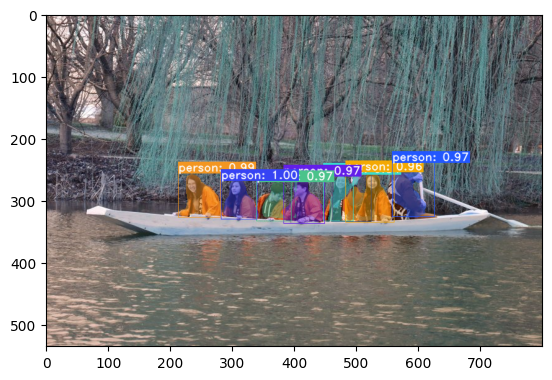

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = np.asarray(Image.open('filename.png'))
imgplot = plt.imshow(img)

*Display separate masks overlaid on the original image for Mask R-CNN and YOLACT here.*

## Question 3 (25 points)

Design an ordinary GAN in which the generator models an "annulus" distribution in $\mathbb{R}^2$. Recall that an annulus distribution has a uniform distribution
over angles around the circle and a radius that is Gaussian with a mean $\mu$ such as 1.0 and standard deviation $\sigma$ such as 0.1. You may use a

Train the GAN and demonstrate that the final generator models the target annulus distribution.

In [3]:
from sklearn.datasets import make_circles
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import time

N_Z_PARAMS = 8

def noise(size):
    # Generates a 1-d vector of gaussian sampled random values
    n = Variable(torch.randn(size, N_Z_PARAMS))
    return n

def plot_data(fig, ax, X1, X2, labels):
    plt.title('Sample')
    ax.plot(X1[:,0], X1[:,1], 'ro', label=labels[0])
    ax.plot(X2[:,0], X2[:,1], 'bo', label=labels[1])
    ax.axis('equal')
    ax.legend()

In [77]:
def pdata_sample(num_sample):
    mu_1 = np.array([1.0, 2.0])
    sigma_1 = 1
    cov_mat = np.matrix([[sigma_1,0],[0,sigma_1]])
    X1 = np.random.multivariate_normal(mean=mu_1, cov=cov_mat, size=num_sample)
    angle = np.random.uniform(0,2*np.pi,num_sample) 
    #random.uniform(low=0.0, high=1.0, size=None)
    d = np.random.normal(np.square(3*sigma_1),np.square(0.5*sigma_1),num_sample) 
    #random.normal(loc=0.0, scale=1.0, size=None)
    X2 = np.array([X1[:,0]+d*np.cos(angle), X1[:,1]+d*np.sin(angle)]).T
    X = np.concatenate([X1,X2],axis=0)
    y = np.append(np.zeros(num_sample), np.zeros(num_sample))
    return X

X = pdata_sample(1000)
samples = torch.Tensor(X)
dataset = torch.utils.data.TensorDataset(samples)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
num_batches = len(data_loader)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


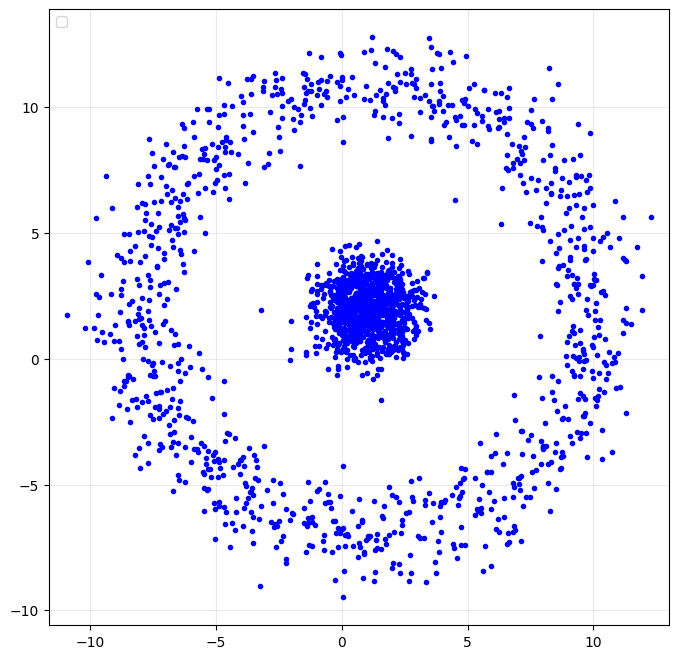

In [81]:
fig1 = plt.figure(figsize=(4,4))
ax = plt.axes() 
plt.grid(axis='both', alpha=.25)
# plot graph here
# YOUR CODE HERE
plt.plot(X[:,0], X[:,1], 'b.')
plt.legend(loc=2)
plt.axis('equal')
plt.show()

In [82]:
class DiscriminatorNet(torch.nn.Module):
    """
    A two hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 8),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(8, 4),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(4, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x


class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = N_Z_PARAMS
        n_out = 2

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 4),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(4, 8),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(8, n_out)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

# Create generator and discriminator

discriminator = DiscriminatorNet()
generator = GeneratorNet()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

def ones_target(size):
    # Tensor containing ones, with shape = size
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    # Tensor containing zeros, with shape = size
    data = Variable(torch.zeros(size, 1))
    return data

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()                               # Reset gradients
    prediction_real = discriminator(real_data)          # Train on real data
    error_real = loss(prediction_real, ones_target(N))  # Calculate error
    error_real.backward()                               # Backpropagate
    prediction_fake = discriminator(fake_data)          # Train on fake data
    error_fake = loss(prediction_fake, zeros_target(N)) # Calculate error
    error_fake.backward()                               # Backpropagate
    optimizer.step()                                    # Update weights with gradients
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)                               
    optimizer.zero_grad()                               # Reset gradients
    d_output = discriminator(fake_data)   
    error = loss(d_output, ones_target(N))              # Calculate error
    error.backward()                                    # Backpropagate
    optimizer.step()                                    # Update weights with gradients
    # Return error
    return error

*Plot results here*

Epoch 0 generator loss 0.754879 discriminator loss 1.347221
Epoch 200 generator loss 0.786957 discriminator loss 1.305564
Epoch 400 generator loss 0.733822 discriminator loss 1.332023
Epoch 600 generator loss 0.707882 discriminator loss 1.368042
Epoch 800 generator loss 0.697122 discriminator loss 1.395471
Epoch 1000 generator loss 0.718013 discriminator loss 1.380408
Epoch 1200 generator loss 0.702276 discriminator loss 1.300616
Epoch 1400 generator loss 0.697229 discriminator loss 1.376612
Epoch 1600 generator loss 0.699693 discriminator loss 1.388225
Epoch 1800 generator loss 0.697700 discriminator loss 1.377006


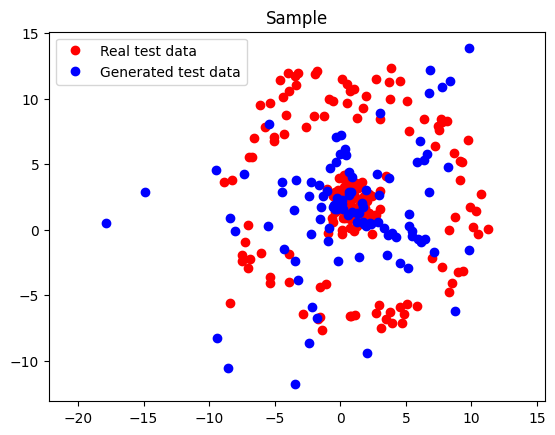

In [85]:
num_test_samples = 100
test_data_real = pdata_sample(num_test_samples)
test_noise = noise(num_test_samples)

num_epochs = 2000
d_error_arr = []
g_error_arr = []
fig,ax = plt.subplots(1,1)
for epoch in range(num_epochs):
    n_batches = 0
    g_error = 0
    d_error = 0
    for n_batch, [real_batch] in enumerate(data_loader):
        N = real_batch.size(0) 
        real_data = Variable(real_batch)
        fake_data = generator(noise(N)).detach()
        d_err, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        d_error += d_err.detach().numpy()
        fake_data = generator(noise(N))
        g_err = train_generator(g_optimizer, fake_data)
        g_error += g_err.detach().numpy()
        n_batches = n_batches + 1
    g_error_arr.append(g_error/n_batches)
    d_error_arr.append(d_error/n_batches)
    if epoch % 200 == 0:
        print('Epoch %d generator loss %f discriminator loss %f' %
            (epoch, g_error_arr[epoch], d_error_arr[epoch]))
    test_data_fake = generator(test_noise).detach()

plot_data(fig, ax, test_data_real, test_data_fake, ['Real test data', 'Generated test data'])

## Question 4 (25 points)

Use the Parzen window idea over the training set (with window size determined using a validation set) to rate the likelihood of your model's parameters.
Plot model likelihood as a function of training epoch for the training you performed in Question 3.

In [86]:
# Place your code here
N_CENTERS = 100
N_PROBES = 100
centers = pdata_sample(N_CENTERS)
probes = pdata_sample(N_PROBES)
sigma = 1.0

def loglike_data(probes):
    loglike = 0
    for probe_i in range(probes.shape[0]):
        p_probe = 0
        for center_i in range(N_CENTERS):
            dist_sq = np.dot(centers[center_i,:] - probes[probe_i,:], centers[center_i,:] - probes[probe_i,:])
            p_probe += np.exp(-dist_sq / 2 / sigma / sigma) / (2 * np.pi * sigma * sigma)
        loglike += np.log(p_probe)
    return loglike

# Original generator

test_data_fake = generator(test_noise).detach().numpy()
ll = loglike_data(test_data_fake)
print(ll)

-1213.0011836417475


*Plot results here*

Epoch 0 generator loss 0.754879 discriminator loss 1.347221
Epoch 200 generator loss 0.786957 discriminator loss 1.305564
Epoch 400 generator loss 0.733822 discriminator loss 1.332023
Epoch 600 generator loss 0.707882 discriminator loss 1.368042
Epoch 800 generator loss 0.697122 discriminator loss 1.395471
Epoch 1000 generator loss 0.718013 discriminator loss 1.380408
Epoch 1200 generator loss 0.702276 discriminator loss 1.300616
Epoch 1400 generator loss 0.697229 discriminator loss 1.376612
Epoch 1600 generator loss 0.699693 discriminator loss 1.388225
Epoch 1800 generator loss 0.697700 discriminator loss 1.377006


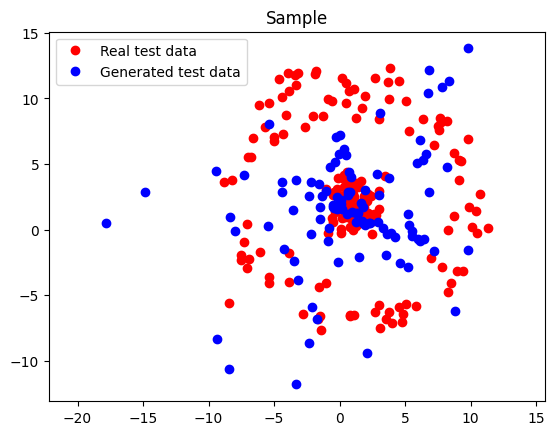

In [87]:
class GeneratorNet2(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GeneratorNet2, self).__init__()
        n_features = N_Z_PARAMS
        n_out = 2

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 4),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(4, n_out)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.out(x)
        return x

# Create generator and discriminator

discriminator2 = DiscriminatorNet()
generator2 = GeneratorNet2()

def train_discriminator2(optimizer, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()                               # Reset gradients
    prediction_real = discriminator2(real_data)          # Train on real data
    error_real = loss(prediction_real, ones_target(N))  # Calculate error
    error_real.backward()                               # Backpropagate
    prediction_fake = discriminator2(fake_data)          # Train on fake data
    error_fake = loss(prediction_fake, zeros_target(N)) # Calculate error
    error_fake.backward()                               # Backpropagate
    optimizer.step()                                    # Update weights with gradients
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator2(optimizer, fake_data):
    N = fake_data.size(0)                               
    optimizer.zero_grad()                               # Reset gradients
    d_output = discriminator2(fake_data)   
    error = loss(d_output, ones_target(N))              # Calculate error
    error.backward()                                    # Backpropagate
    optimizer.step()                                    # Update weights with gradients
    # Return error
    return error

num_epochs = 2000
d_error_arr_2 = []
g_error_arr_2 = []
fig,ax = plt.subplots(1,1)
for epoch in range(num_epochs):
    n_batches = 0
    g_error = 0
    d_error = 0
    for n_batch, [real_batch] in enumerate(data_loader):
        N = real_batch.size(0) 
        real_data = Variable(real_batch)
        fake_data = generator2(noise(N)).detach()
        d_err, d_pred_real, d_pred_fake = train_discriminator2(d_optimizer, real_data, fake_data)
        d_error += d_err.detach().numpy()
        fake_data = generator2(noise(N))
        g_err = train_generator2(g_optimizer, fake_data)
        g_error += g_err.detach().numpy()
        n_batches = n_batches + 1
    g_error_arr.append(g_error/n_batches)
    d_error_arr.append(d_error/n_batches)
    if epoch % 200 == 0:
        print('Epoch %d generator loss %f discriminator loss %f' %
          (epoch, g_error_arr[epoch], d_error_arr[epoch]))
    test_data_fake = generator(test_noise).detach()
    
plot_data(fig, ax, test_data_real, test_data_fake, ['Real test data', 'Generated test data'])